<a href="https://colab.research.google.com/github/ctarrington/data-science-hw/blob/master/dbda/ch09-heirarchical-models/heirarchical_on_mint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
from runpy import run_path

az.style.use('arviz-darkgrid')
%matplotlib inline

In [15]:
!rm -rf data-science-hw
!git clone https://github.com/ctarrington/data-science-hw.git

base_path = './data-science-hw/dbda/ch08-basic-models/'
Coin = run_path(base_path+'/mint.py').get('Coin')
Mint = run_path(base_path+'/mint.py').get('Mint')

Cloning into 'data-science-hw'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 166 (delta 76), reused 29 (delta 6), pack-reused 0
Receiving objects: 100% (166/166), 3.30 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [16]:
coins_per_mint = 10
mint = Mint(0.2, 0.025)
coins = mint.make_coins(coins_per_mint)

mint = Mint(0.8, 0.025)
mint.make_coins(coins_per_mint, coins)

In [17]:
flips = []
for ctr in range(100):
  for coin in coins:
    coin.flip(flips)

In [18]:
df = pd.DataFrame(flips, columns=['mint_id', 'coin_id', 'flip'])
df.head()

,mint_id,coin_id,flip
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,1
4,0,4,1


In [19]:
coin_id = df['coin_id']
mint_id = df['mint_id']

num_coins = len(np.unique(coin_id))
num_mints = len(np.unique(mint_id))

print('num_coins', num_coins)
print('num_mints', num_mints)

num_coins 20
num_mints 2


## No Heirarchy - Coins

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ_coin]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:10<00:00, 236.79it/s]
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


             mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
θ_coin[0]   0.176  0.038   0.101    0.242  ...  7837.0    8260.0    2823.0    1.0
θ_coin[1]   0.176  0.038   0.110    0.247  ...  9031.0    9427.0    3039.0    1.0
θ_coin[2]   0.119  0.032   0.062    0.180  ...  6742.0    8564.0    2867.0    1.0
θ_coin[3]   0.207  0.040   0.135    0.287  ...  6441.0    7293.0    3065.0    1.0
θ_coin[4]   0.168  0.037   0.105    0.240  ...  7472.0    8793.0    2885.0    1.0
θ_coin[5]   0.284  0.046   0.200    0.372  ...  8808.0    9230.0    3207.0    1.0
θ_coin[6]   0.235  0.041   0.161    0.312  ...  7464.0    7586.0    3207.0    1.0
θ_coin[7]   0.176  0.038   0.107    0.245  ...  6974.0    8114.0    2981.0    1.0
θ_coin[8]   0.156  0.036   0.088    0.225  ...  7171.0    8361.0    2578.0    1.0
θ_coin[9]   0.157  0.035   0.093    0.222  ...  7214.0    6911.0    3058.0    1.0
θ_coin[10]  0.834  0.036   0.764    0.899  ...  7622.0    7387.0    2976.0    1.0
θ_coin[11]  0.77

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarnin

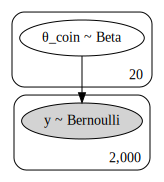

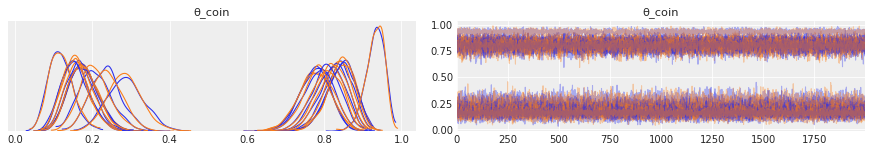

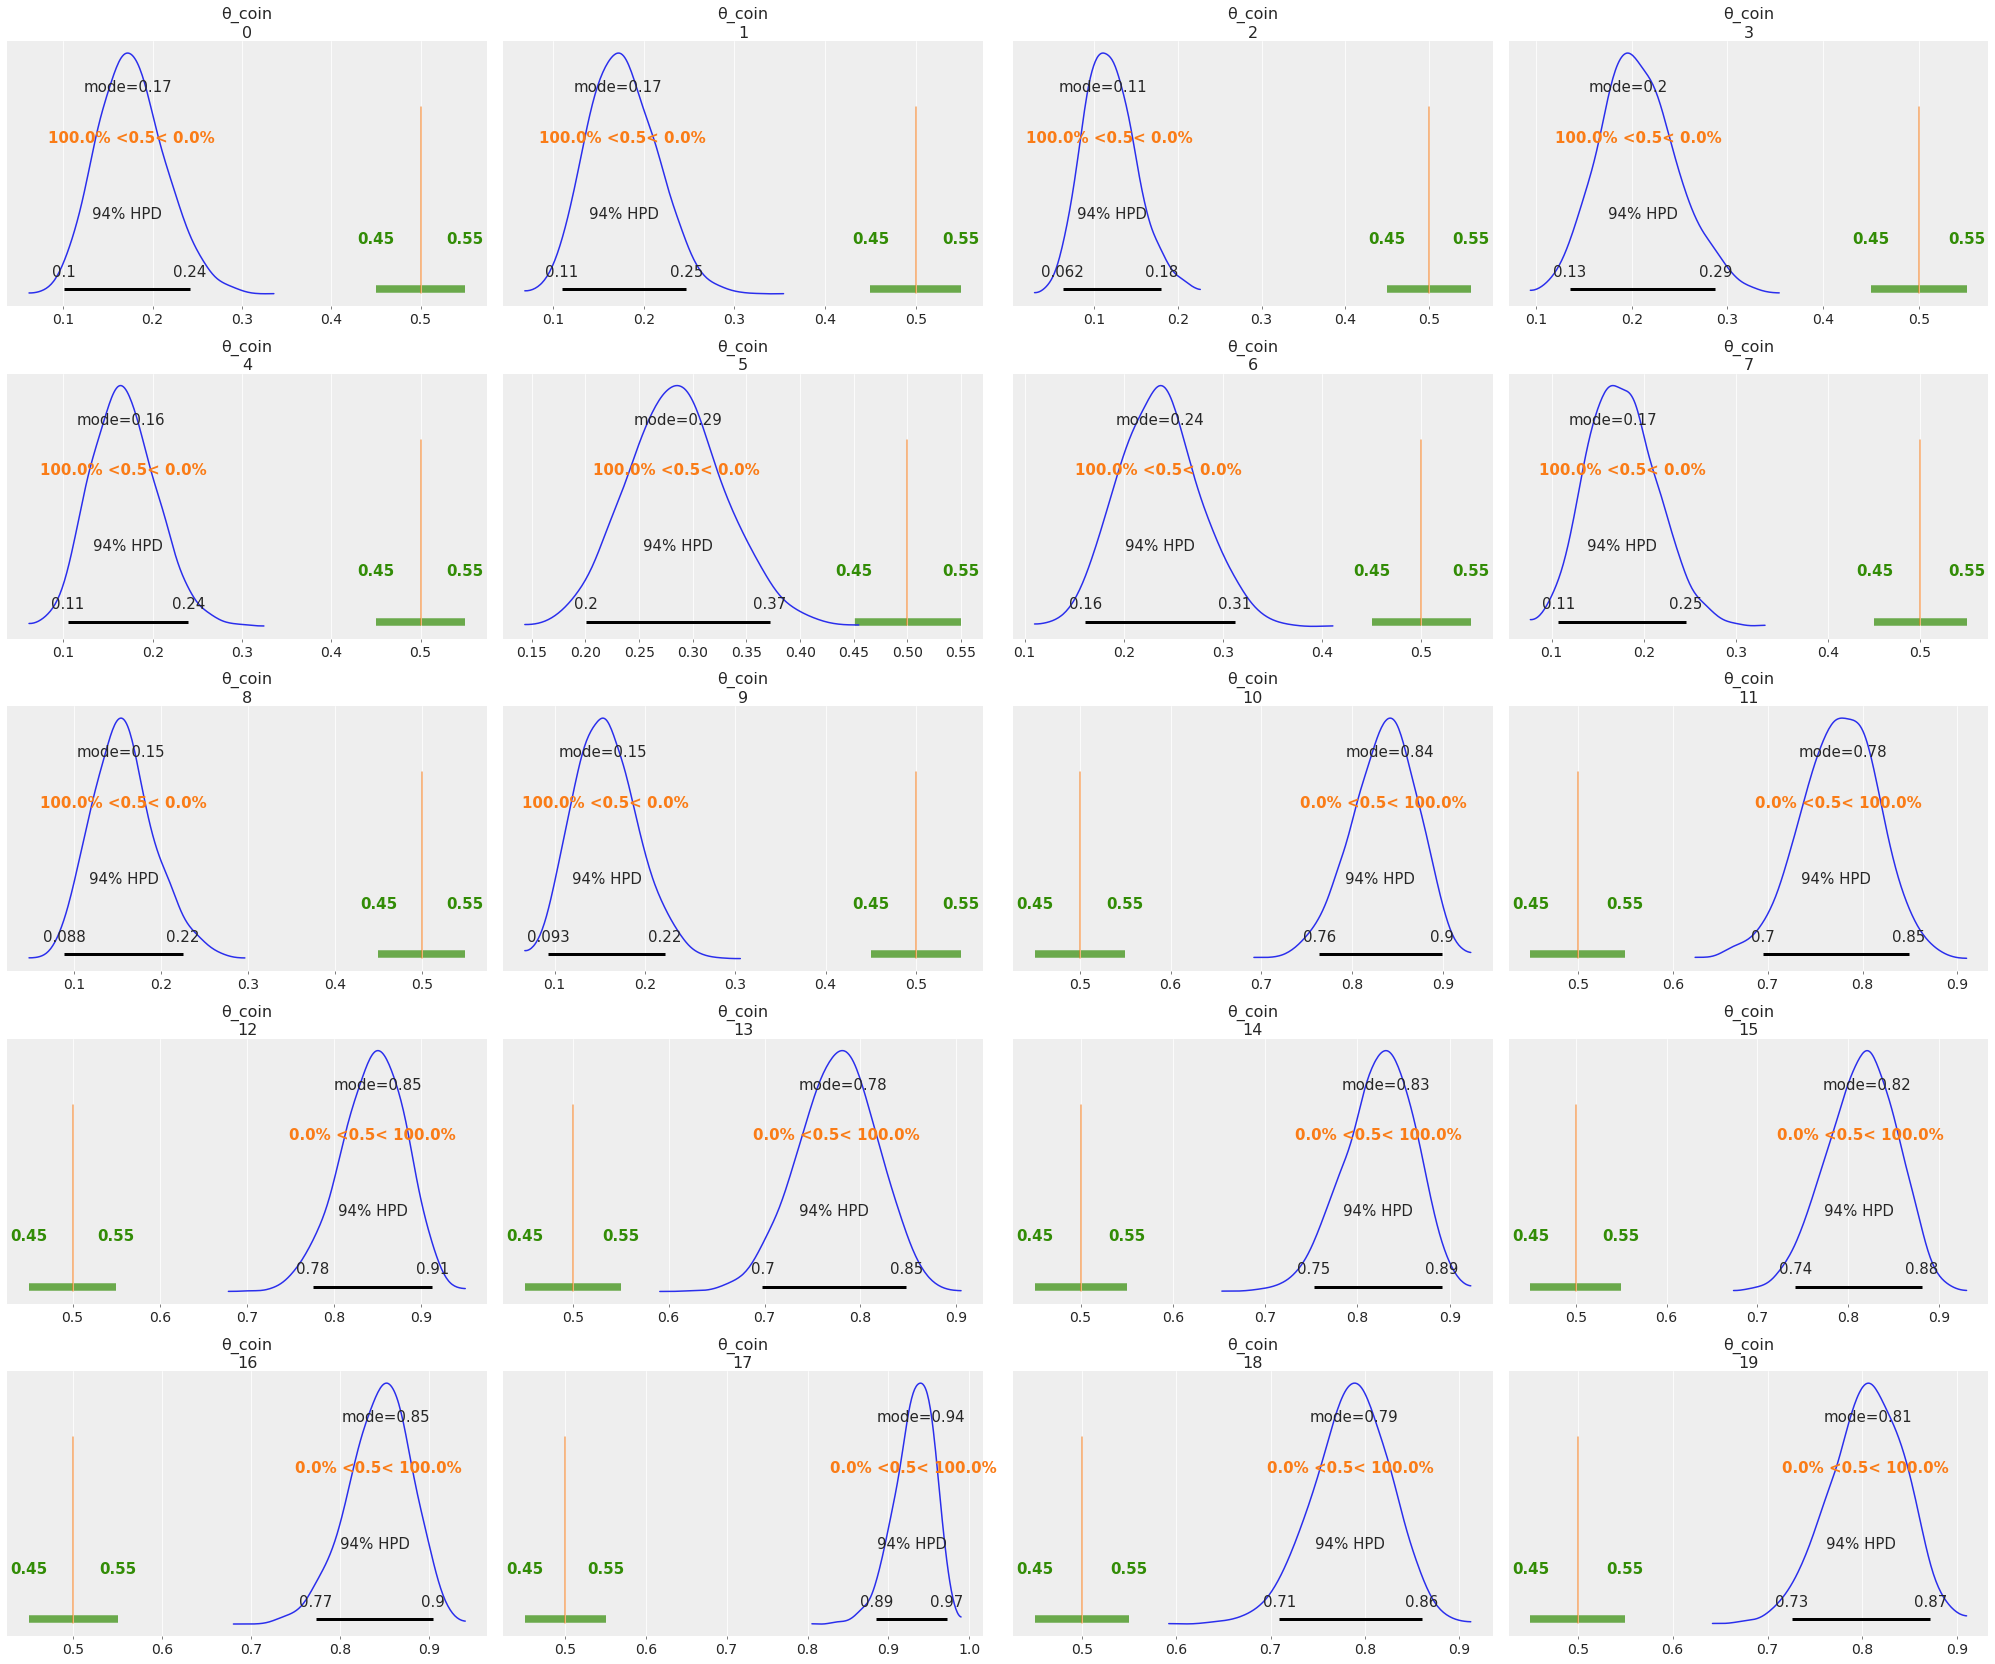

In [20]:
with pm.Model() as model:
  θ_coin = pm.Beta('θ_coin', alpha=1., beta=1., shape=num_coins)   # uniform prior
  
  y = pm.Bernoulli('y', p=θ_coin[coin_id], observed=df['flip']) # likelihood p(y|θ)

  trace_nh_coins = pm.sample(2000, random_seed=123)
  print(az.summary(trace_nh_coins))
  pm.traceplot(trace_nh_coins)
  az.plot_posterior(trace_nh_coins, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model)

## No Heirarchy - Mints


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [μ_mint]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:04<00:00, 500.51it/s]
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


            mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
μ_mint[0]  0.179  0.012   0.156    0.202  ...  3623.0    3621.0    2753.0    1.0
μ_mint[1]  0.828  0.012   0.807    0.851  ...  3871.0    3858.0    2703.0    1.0

[2 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarnin

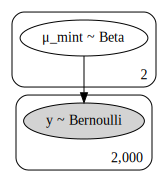

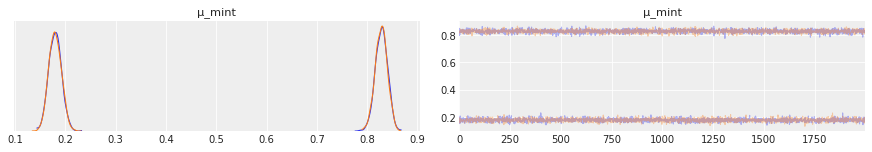

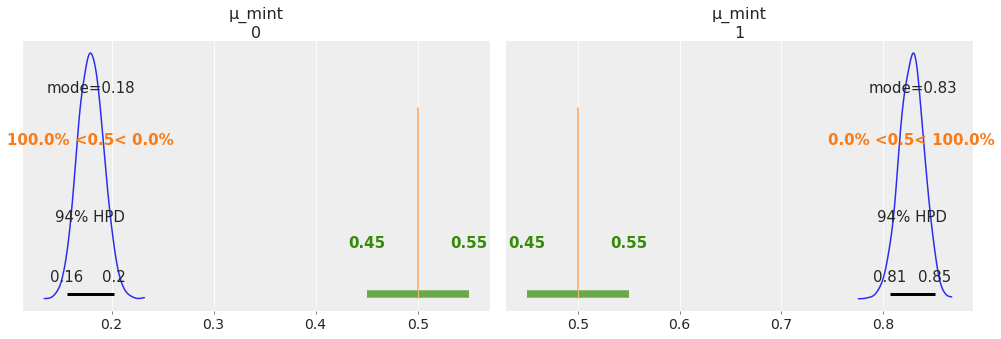

In [21]:
mint_id = df['mint_id']

with pm.Model() as model:
  μ_mint = pm.Beta('μ_mint', alpha=1., beta=1., shape=num_mints)   # uniform prior
  
  y = pm.Bernoulli('y', p=μ_mint[mint_id], observed=df['flip']) # likelihood p(y|θ)

  trace_nh_mints = pm.sample(2000, random_seed=123)
  print(az.summary(trace_nh_mints))
  pm.traceplot(trace_nh_mints)
  az.plot_posterior(trace_nh_mints, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model)

## Heirarchy under Mint

In [22]:
grouped = df.groupby(['mint_id', 'coin_id']).agg({'flip': [np.sum, np.size]}).reset_index()
grouped.columns = ['mint_id', 'coin_id', 'heads', 'total']

# mint id series needs to be the length of the mints
mint_id = grouped['mint_id']

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ_coin, concentration_mint, μ_mint]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:13<00:00, 187.55it/s]
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__get

                         mean     sd  hpd_3%  ...  ess_bulk  ess_tail  r_hat
μ_mint[0]               0.196  0.032   0.138  ...    5876.0    2960.0    1.0
μ_mint[1]               0.812  0.032   0.752  ...    6158.0    3213.0    1.0
concentration_mint[0]  19.082  6.294   7.524  ...    6145.0    2996.0    1.0
concentration_mint[1]  18.296  6.208   8.157  ...    6211.0    3120.0    1.0
θ_coin[0]               0.174  0.035   0.106  ...    9310.0    3252.0    1.0
θ_coin[1]               0.173  0.034   0.112  ...    9677.0    3173.0    1.0
θ_coin[2]               0.123  0.030   0.069  ...    7478.0    3044.0    1.0
θ_coin[3]               0.199  0.037   0.134  ...    8264.0    3151.0    1.0
θ_coin[4]               0.166  0.035   0.107  ...    8669.0    2944.0    1.0
θ_coin[5]               0.266  0.042   0.189  ...   12745.0    3283.0    1.0
θ_coin[6]               0.225  0.038   0.150  ...    8798.0    3068.0    1.0
θ_coin[7]               0.174  0.035   0.114  ...    8799.0    3060.0    1.0

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarnin

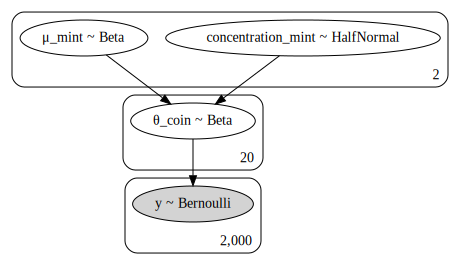

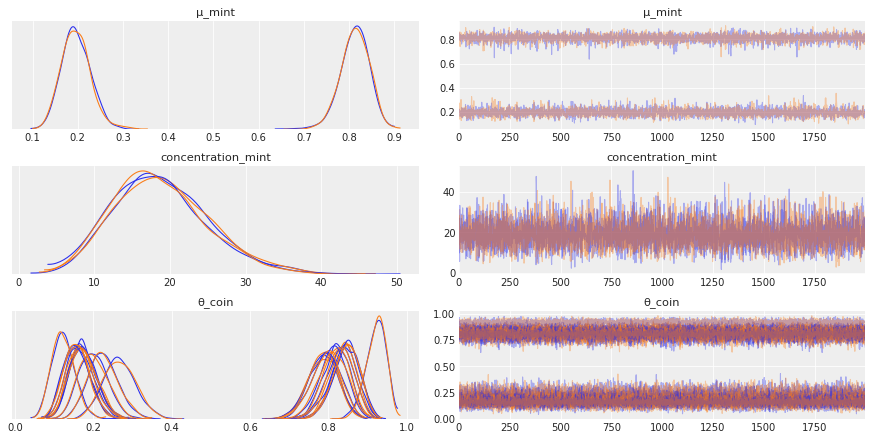

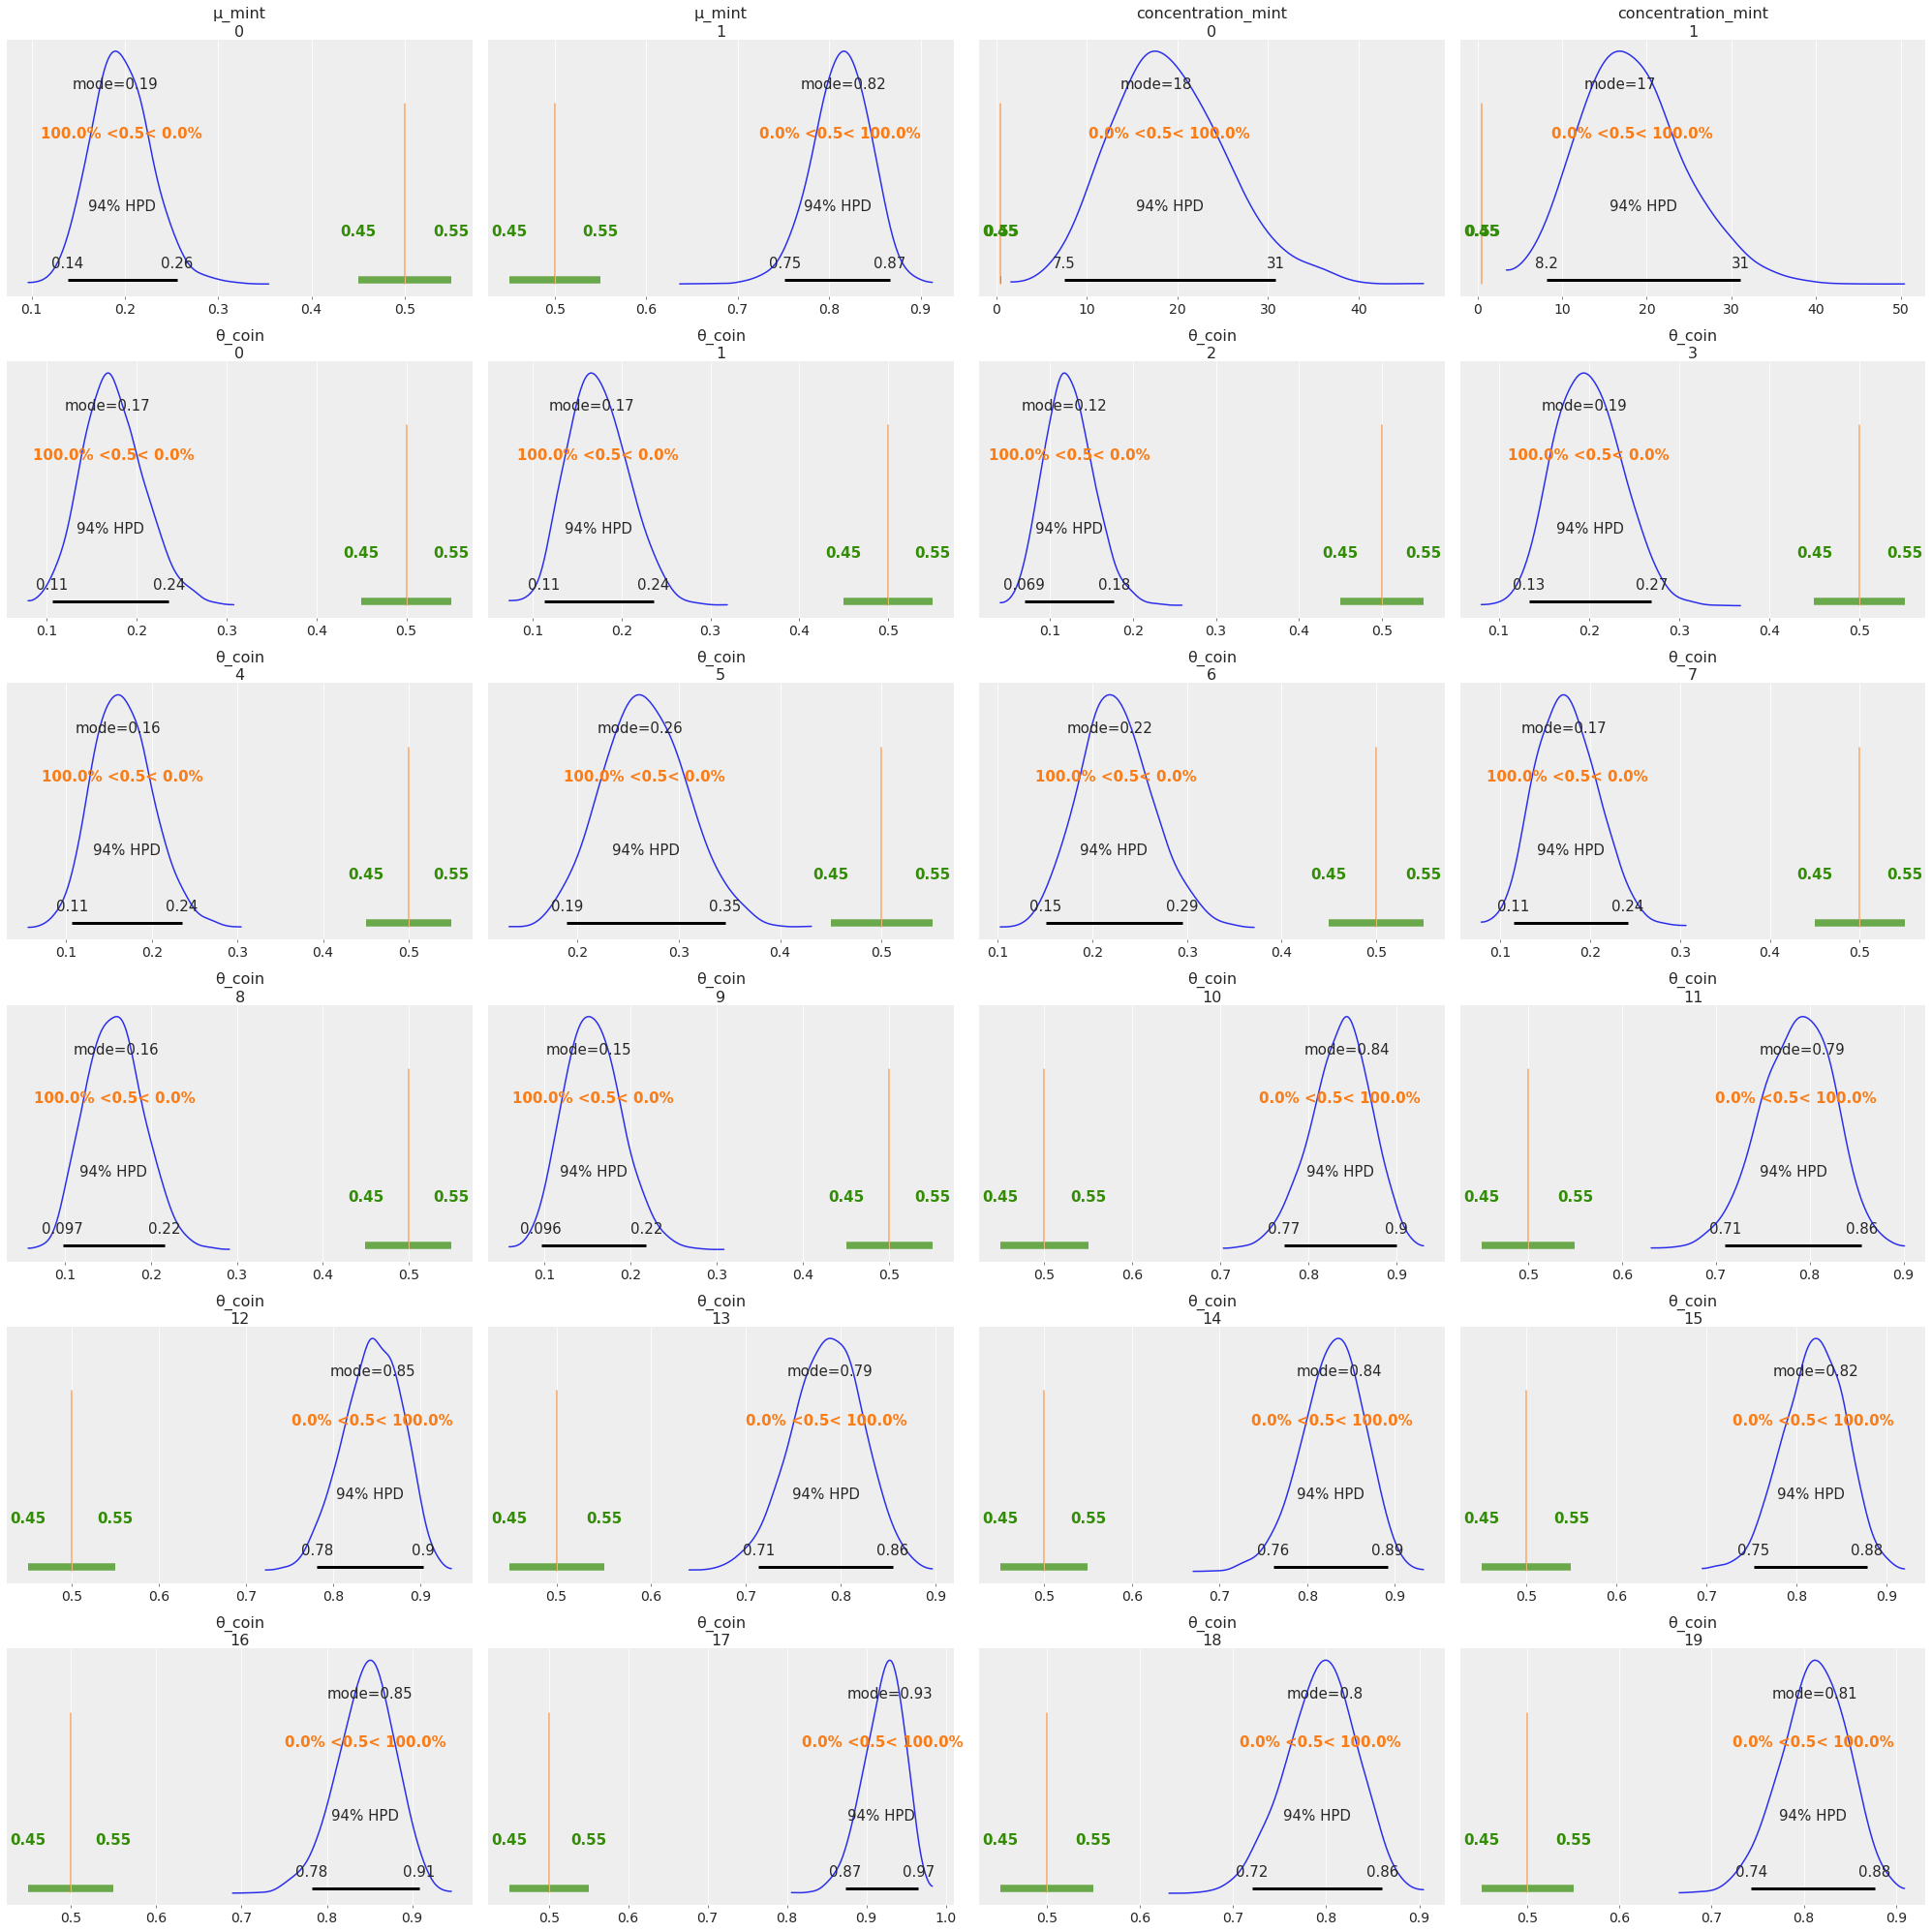

In [23]:
with pm.Model() as model_h_mint:
    μ_mint = pm.Beta('μ_mint', 1, 1, shape=num_mints)
    concentration_mint = pm.HalfNormal('concentration_mint', 10, shape=num_mints)    

    θ_coin = pm.Beta('θ_coin', alpha=μ_mint[mint_id]*concentration_mint[mint_id], beta=(1.0-μ_mint[mint_id])*concentration_mint[mint_id], shape=num_coins)
    y = pm.Bernoulli('y', p=θ_coin[coin_id], observed=df['flip']) # likelihood p(y|θ)
  
    trace_h_mints = pm.sample(2000, random_seed=123)
    print(az.summary(trace_h_mints))
    pm.traceplot(trace_h_mints)
    az.plot_posterior(trace_h_mints, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_h_mint)

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f803ae5d2b0>],
      dtype=object)

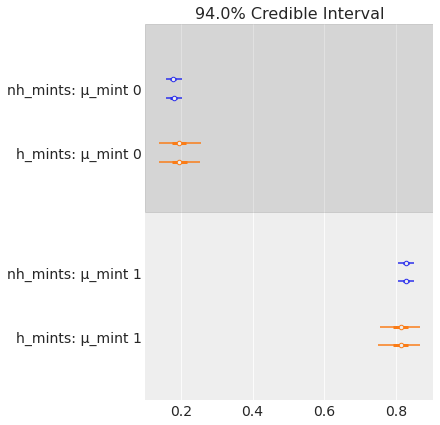

In [24]:
az.plot_forest([trace_nh_mints, trace_h_mints],
               model_names=['nh_mints', 'h_mints'],
               var_names='μ_mint',
               combined=False,
               colors='cycle')

## Shrinkage towards modes (not much)

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f802ea1ff60>],
      dtype=object)

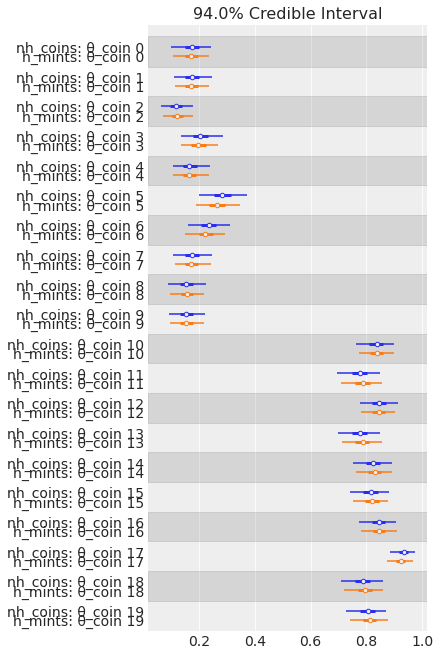

In [25]:
az.plot_forest([trace_nh_coins, trace_h_mints],
               model_names=['nh_coins', 'h_mints'],
               var_names='θ_coin',
               combined=True,
               colors='cycle')